**Motivação**
1. O ciclo de vida do cliente e a definição do problema - aprovação de Cartão de Crédito <br>
2. Lidando com os valores faltantes (missing values)  <br>
3. Convertendo valores categóricos em numéricos e análise exploratória (AED) <br>
4. Separando a base entre treinamento e teste <br>
5. Treinamento da Regressão Logística <br>
6. Avaliação do modelo <br>

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import sklearn.metrics as metrics
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
import os
os.chdir("C:\\Users\\dalto\\Desktop\\Estágio\\Data Science")

dol = pd.read_excel("PredDolarInv3.xlsx")
dol

,Data,Abertura,Máxima,Mínima,Fechamento,BollingerSup,BollingerInf
0,2014-01-02,3841.71,3895.47,3841.71,3860.16,3885.81,3737.85
1,2014-01-03,3846.52,3860.97,3828.07,3842.51,3886.74,3737.68
2,2014-01-06,3835.29,3854.55,3832.08,3846.52,3884.99,3738.32
3,2014-01-07,3835.29,3840.10,3805.60,3832.88,3872.71,3744.58
4,2014-01-08,3838.50,3872.20,3823.25,3869.79,3878.76,3741.86
...,...,...,...,...,...,...,...
1887,2021-08-19,5427.50,5464.50,5388.50,5425.50,5387.28,5096.27
1888,2021-08-20,5455.00,5484.00,5373.00,5383.00,5407.33,5092.02
1889,2021-08-23,5373.50,5408.50,5352.00,5388.00,5425.92,5092.19
1890,2021-08-24,5370.00,5370.50,5251.00,5257.00,5426.34,5098.23


In [37]:
dol["Alvo"] = np.where(dol["Fechamento"].shift(-1) > dol["Fechamento"] , 1, 0)

dol["DistBoll"] = (dol["BollingerSup"] - dol["BollingerInf"])
dol["MMDistBoll15"] = dol["DistBoll"].rolling(15).mean()

# Desvio Padrão
dol["std5"] = dol["Fechamento"].rolling(5).std()
dol["std15"] = dol["Fechamento"].rolling(15).std()

# Proporção do corpo do candle em relação ao range do dia
dol["prop"] = (dol["Fechamento"]-dol["Abertura"])/(dol["Máxima"]-dol["Mínima"])

# Direção do dia atual
dol["dirD"] = np.where(dol["Fechamento"] > dol["Abertura"], '1', '0')
dol["dirD-1"] = dol["dirD"].shift(1)
dol["dirD-2"] = dol["dirD"].shift(2)
dol["dirD-3"] = dol["dirD"].shift(3)

# Média móvel de 15 dias
dol["MM"] = dol["Fechamento"].rolling(15).mean()

# Zscore
dol["zscore"] = (dol["Fechamento"]-dol["MM"])/dol["std15"]

# RSL
dol["RSL"] = (dol["Fechamento"]/dol["MM"])-1

dol["DistBoll-1"] = dol["DistBoll"].shift(1)
dol["DistBoll-2"] = dol["DistBoll"].shift(2)
dol["DistBoll-3"] = dol["DistBoll"].shift(3)

dol["Pips"] = (dol["Fechamento"].shift(1) - dol["Fechamento"])

dol["Pips-1"] = dol["Pips"].shift(1)
dol["Pips-2"] = dol["Pips"].shift(2)
dol["Pips-3"] = dol["Pips"].shift(3)

In [38]:
dol["std5"] = pd.qcut(dol["std5"], 10, labels = False)
dol["std15"] = pd.qcut(dol["std15"], 10, labels = False)
#dol["DistBoll"] = pd.qcut(dol["DistBoll"], 10, labels = False)
#dol["DistBoll-1"] = pd.qcut(dol["DistBoll-1"], 10, labels = False)
dol["prop"] = pd.qcut(dol["prop"], 10, labels = False)
dol["MMDistBoll15"] = pd.qcut(dol["MMDistBoll15"], 10, labels = False)

In [39]:
dol = dol.drop(["Abertura", "Mínima", "Máxima", "BollingerSup", "BollingerInf", "Fechamento"], axis = 1)

In [40]:
dol["Data"] = pd.to_datetime(dol["Data"]).dt.normalize()
dol = dol.set_index("Data")
dol.head()

,Alvo,DistBoll,MMDistBoll15,std5,std15,prop,dirD,dirD-1,dirD-2,dirD-3,MM,zscore,RSL,DistBoll-1,DistBoll-2,DistBoll-3,Pips,Pips-1,Pips-2,Pips-3
Data,,,,,,,,,,,,,,,,,,,,
2014-01-02,0,147.96,NaN,NaN,NaN,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,1,149.06,NaN,NaN,NaN,4,0,1,NaN,NaN,NaN,NaN,NaN,147.96,NaN,NaN,17.65,NaN,NaN,NaN
2014-01-06,0,146.67,NaN,NaN,NaN,7,1,0,1,NaN,NaN,NaN,NaN,149.06,147.96,NaN,-4.01,17.65,NaN,NaN
2014-01-07,1,128.13,NaN,NaN,NaN,4,0,1,0,1,NaN,NaN,NaN,146.67,149.06,147.96,13.64,-4.01,17.65,NaN
2014-01-08,0,136.90,NaN,0.0,NaN,8,1,0,1,0,NaN,NaN,NaN,128.13,146.67,149.06,-36.91,13.64,-4.01,17.65


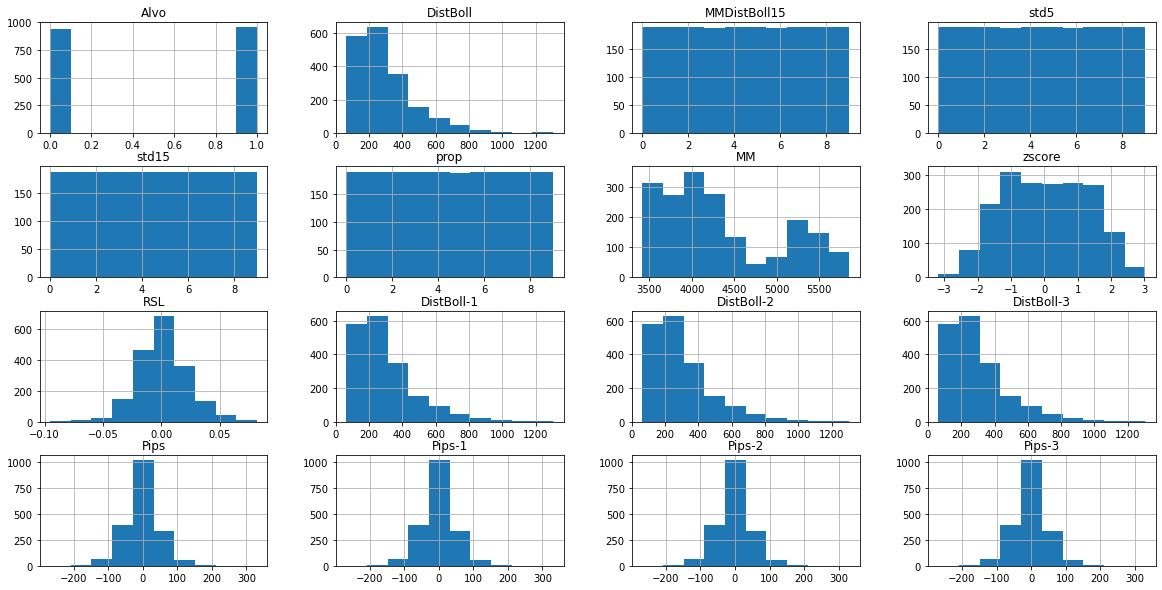

In [41]:
# Como todas as variáveis são numéricas, vamos plotar seus respectivos histogramas

dol.hist()
plt.gcf().set_size_inches(20,10)

In [42]:
#dol = dol.fillna(method = "ffill")
dol = dol.dropna(axis=0)
dol.isna().sum().sum()

0

**É importante saber interpretar os dados dos histogramas em alguns casos é possível perceber uma certa correlação ou tendência<br>
na var2 é possível perceber que ela segue uma linearidade até certo ponto e depois foge do esperado.<br><br>
Essa variável pode ser muito boa, no entanto essa distorção de ponta pode fazer com que o modelo <br>
dê menos importância do que deveria, nesse caso é interessante trabalhar essa variável dividindo ela em partes<br>**

In [43]:
# Cria intervalos da variável var2
#var2X = list(range(baseCC.var2.min(), baseCC.var2.max()+50, 50)) # o +50 foi usado por ter havido um erro na criação
# cria uma lista do valor mín ao máx de var2, dividindo-0 de 50 em 50

# Cria o nome dos intervalos
#nomeX = [f'var_i{i}' for i in range(len(var2X)-1)]
# Criei um laço for para automatizar a criação dos nomes das variáveis

# Atribui ao data frame
#baseCC['var2X'] =  pd.cut(baseCC.var2, var2X, labels = nomeX, include_lowest = True)
# uso a função pd.cut para (que variável cortar, os intervalos, os labels, incluindo o menor valor)

In [44]:
# Criar tabela cruzada para analise dos dados

# método pd.crosstab usando como referência(index) o "alvo" e se baseando na variável criada "var2X" 
#crossDol = pd.crosstab(index = dol["Alvo"], columns = dol["DistBoll"])
#dol.index = ["Rejected", "Accepted"]

#crossDol

**A variável nova foi criada como do tipo categoria, como o modelo necessita que trabalhemos com variáveis numéricas temos que mudar isso**

In [45]:
#EXERCÍCIO: Fazer com var3 e var14 o mesmo que foi feito com var2
print(dol["Pips"].describe())
print()
print(dol["DistBoll-1"].describe())


count    1878.000000
mean       -0.754798
std        50.544927
min      -268.850000
25%       -28.385000
50%        -0.635000
75%        26.037500
max       331.070000
Name: Pips, dtype: float64

count    1878.000000
mean      297.614867
std       180.443194
min        61.990000
25%       172.582500
50%       250.755000
75%       371.032500
max      1305.850000
Name: DistBoll-1, dtype: float64


# 4. Separando a base entre treinamento e teste


In [46]:
# Separandp os dados como variáveis  e alvo

sTrain = "2014-02-12"
eTrain = "2018-12-31"
# Teste de 2020.2 até agora 
sTest = "2019-01-01"
eTest = "2021-08-25"


dolTrain = dol[sTrain : eTrain]
dolTest = dol[sTest : eTest]


In [47]:
xTrain = dolTrain.drop("Alvo", axis = 1)
yTrain = dolTrain["Alvo"]

xTest = dolTest.drop("Alvo", axis = 1)
yTest = dolTest["Alvo"]

# 5. Treinamento da Regressão Logística

In [48]:
dol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1878 entries, 2014-01-22 to 2021-08-25
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Alvo          1878 non-null   int32  
 1   DistBoll      1878 non-null   float64
 2   MMDistBoll15  1878 non-null   float64
 3   std5          1878 non-null   float64
 4   std15         1878 non-null   float64
 5   prop          1878 non-null   int64  
 6   dirD          1878 non-null   object 
 7   dirD-1        1878 non-null   object 
 8   dirD-2        1878 non-null   object 
 9   dirD-3        1878 non-null   object 
 10  MM            1878 non-null   float64
 11  zscore        1878 non-null   float64
 12  RSL           1878 non-null   float64
 13  DistBoll-1    1878 non-null   float64
 14  DistBoll-2    1878 non-null   float64
 15  DistBoll-3    1878 non-null   float64
 16  Pips          1878 non-null   float64
 17  Pips-1        1878 non-null   float64
 18  Pips-2    

In [49]:
categorias = {"dirD": {"0": 0 ,"1": 1, "2": 2 ,"3": 3 ,"4": 4 ,"5": 5,"6": 6 ,"7": 7 ,"8": 8,"9": 9 }}
dol.replace(categorias,inplace = True)
categorias = {"dirD-1": {"0": 0 ,"1": 1, "2": 2 ,"3": 3 ,"4": 4 ,"5": 5,"6": 6 ,"7": 7 ,"8": 8,"9": 9 }}
dol.replace(categorias,inplace = True)
categorias = {"dirD-2": {"0": 0 ,"1": 1, "2": 2 ,"3": 3 ,"4": 4 ,"5": 5,"6": 6 ,"7": 7 ,"8": 8,"9": 9 }}
dol.replace(categorias,inplace = True)
categorias = {"dirD-3": {"0": 0 ,"1": 1, "2": 2 ,"3": 3 ,"4": 4 ,"5": 5,"6": 6 ,"7": 7 ,"8": 8,"9": 9 }}
dol.replace(categorias,inplace = True)

dol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1878 entries, 2014-01-22 to 2021-08-25
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Alvo          1878 non-null   int32  
 1   DistBoll      1878 non-null   float64
 2   MMDistBoll15  1878 non-null   float64
 3   std5          1878 non-null   float64
 4   std15         1878 non-null   float64
 5   prop          1878 non-null   int64  
 6   dirD          1878 non-null   int64  
 7   dirD-1        1878 non-null   int64  
 8   dirD-2        1878 non-null   int64  
 9   dirD-3        1878 non-null   int64  
 10  MM            1878 non-null   float64
 11  zscore        1878 non-null   float64
 12  RSL           1878 non-null   float64
 13  DistBoll-1    1878 non-null   float64
 14  DistBoll-2    1878 non-null   float64
 15  DistBoll-3    1878 non-null   float64
 16  Pips          1878 non-null   float64
 17  Pips-1        1878 non-null   float64
 18  Pips-2    

In [53]:
# inicializa a instancia e treina o modelo

# Adicionando os intercepts
xTrainn = sm.add_constant(xTrain)
xTestt = sm.add_constant(xTest)

regLog = sm.GLM(yTrain.astype(float), xTrainn.astype(float), family = sm.families.Binomial())
regLog = regLog.fit()

print(regLog.summary())
print()
print('Parameters: ', regLog.params)
print()
print("Odds ratio")
print(np.exp(regLog.params))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Alvo   No. Observations:                 1205
Model:                            GLM   Df Residuals:                     1185
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -817.70
Date:                Thu, 26 Aug 2021   Deviance:                       1635.4
Time:                        19:20:15   Pearson chi2:                 1.20e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.6109      0.685      2.353   

In [ ]:
#EXERCÍRCIO: refazer o modelo removendo as variáveis var4 e var5

# 6. Avaliação do modelo

In [56]:
# Fazendo a previsão na base de treinamento e na base de teste

predTrain = regLog.predict(xTrainn.astype(float))
predTest = regLog.predict(xTestt.astype(float))

In [57]:
# Calculando a ROC e o Gini - Treinamento
fprTrain, tprTrain, thresholdsTrain = roc_curve(yTrain, predTrain)
roc_auc_train = auc(fprTrain, tprTrain)

print('AUC - Treinamento : %f' % roc_auc_train)
print("Gini - Treinamento: ", round(2*roc_auc_train-1,2))
print()

# Calculando a ROC e o Gini - Treinamento
fprTest, tprTest, thresholdsTest = roc_curve(yTest, predTest)
roc_auc_test = auc(fprTest, tprTest)

print('AUC - Teste : %f' % roc_auc_test)
print("Gini - Teste: ", round(2*roc_auc_test-1,2))


AUC - Treinamento : 0.593310
Gini - Treinamento:  0.19

AUC - Treinamento : 0.531203
Gini - Treinamento:  0.06


In [58]:
# Muito importante
# Qual é o melhor ponto de corte para a aceitação do pedido de cartão de crédito
# O cruzamento entre true Positive Rate e False positive Rate - onde TPR é mais alta e FPR é mais baixa

i = np.arange(len(tprTrain))
rocTrain = pd.DataFrame ({ 'fpr'        : pd.Series(fprTrain, index = i)
                         , 'tpr'        : pd.Series(tprTrain, index = i)
                         , '1-fpr'      : pd.Series(1-fprTrain, index = i)
                         , 'tf'         : pd.Series(tprTrain - (1-fprTrain), index = i)
                         , 'thresholds' : pd.Series(thresholdsTrain, index = i)})

print(round(rocTrain.loc[(rocTrain.tf-0).abs().argsort()[:1]],3))
print()
print("ponto de corte otimo: ???")

       fpr   tpr  1-fpr     tf  thresholds
292  0.432  0.56  0.568 -0.008       0.497

ponto de corte otimo: 0.425


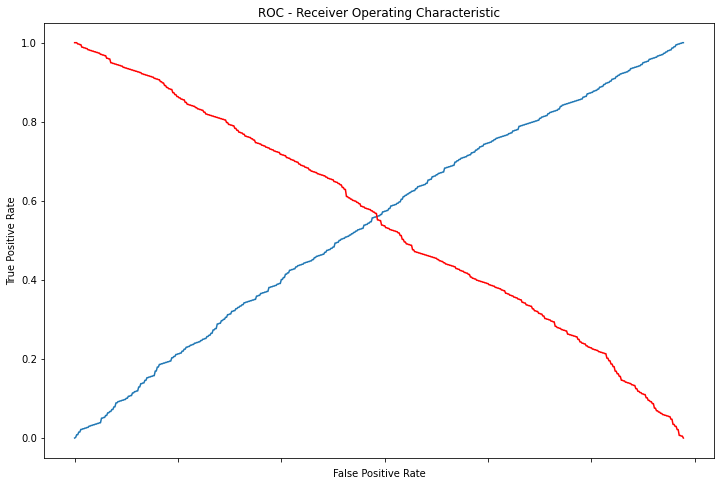

In [59]:
# Plotando a ROC(AUC) - Treinamento

fig, ax = plt.subplots()
plt.plot(rocTrain['tpr'])
plt.plot(rocTrain['1-fpr'], color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver Operating Characteristic')
ax.set_xticklabels([]);
plt.gcf().set_size_inches(12,8)

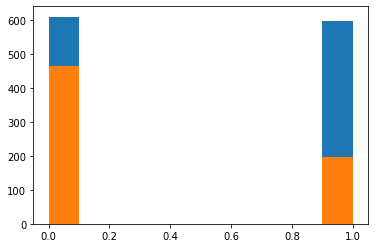

In [74]:
# Ajustando o ponto de corte

cutoff = 0.6

# Veja que os scores finais não são tão granulares (base pequena/poucas variáveis)
# e há concentração no 1

plt.hist(predTrain)
plt.hist(predTest);

# O efeito aqui será limitado pelo exemplo, mas em bases maiores o impacto é enorme

In [75]:
# Pre-processamento para a amtriz de confusão - Os dados devem ser binários

from sklearn.metrics import confusion_matrix

predTrainBin = predTrain
predTestBin = predTest

# Percorrendo e transformando todas as probabilidades do treinamento
for score in range (0, len(predTrain-1)):
    if predTrain.iloc[score] >= cutoff:
        predTrainBin.iloc[score] = 1
    else:
        predTrainBin.iloc[score] = 0
        
# Percorrendo e transformando todas as probabilidades do teste
for score in range (0, len(predTest-1)):
    if predTest.iloc[score] >= cutoff:
        predTestBin.iloc[score] = 1
    else:
        predTestBin.iloc[score] = 0

In [76]:
# Avaliando a base de treinamento
print("valiando a base de treinamento")
print(confusion_matrix(yTrain, predTrainBin))
print()
print("Acurácia: ", round(metrics.accuracy_score(yTrain, predTrainBin)*100,3))
# Avaliando a base de teste
print("valiando a base de teste")
print(confusion_matrix(yTest, predTestBin))

print("Acurácia: ", round(metrics.accuracy_score(yTest, predTestBin)*100,3))

valiando a base de treinamento
[[346 263]
 [263 333]]

Acurácia:  56.349
valiando a base de teste
[[228  85]
 [235 110]]
Acurácia:  51.368
